In [1]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
#Setting Scanpy figure parameters 
sc.settings.set_figure_params(dpi = 500, color_map = 'RdPu', dpi_save = 500)

In [4]:
adata_allcells = sc.read_h5ad("./adata_Final_for_Reinfection_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['leiden_lab_orig'].isin(['TNK cells']), :]
adata

View of AnnData object with n_obs × n_vars = 44669 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [6]:
adata.raw = adata.copy()
# keep blacklist genes from vars (they are stored in .raw so still accessible)
adata = adata[:,~adata.var['Blacklist_Genes']]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata.var['highly_variable'].value_counts()
adata

AnnData object with n_obs × n_vars = 44669 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

# 1. Regress out cell cycle genes

In [7]:
# list source: https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt
regev_lab_cell_cycle_genes_list = [
    "MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", "MCM6",
    "CDCA7", "DTL", "PRIM1", "UHRF1", "MLF1IP", "HELLS", "RFC2", "RPA2", "NASP", "RAD51AP1",
    "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2",
    "CDC45", "CDC6", "EXO1", "TIPIN", "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1",
    "CHAF1B", "BRIP1", "E2F8", "HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A",
    "NDC80", "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "FAM64A", "SMC4",
    "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", "TUBB4B", "GTSE1", "KIF20B",
    "HJURP", "CDCA3", "HN1", "CDC20", "TTK", "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5",
    "CDCA2", "CDCA8", "ECT2", "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5",
    "CENPE", "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"
]


In [8]:
s_genes = regev_lab_cell_cycle_genes_list[:43]
g2m_genes = regev_lab_cell_cycle_genes_list[43:]
cell_cycle_genes = [x for x in regev_lab_cell_cycle_genes_list if x in adata.var_names]
print(len(cell_cycle_genes))

96


In [9]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

In [ ]:
sc.tl.pca(adata, svd_solver = 'arpack', random_state = 18,use_highly_variable=True)
sc.pl.pca(adata, components=['1,2', '3,4'], color=['Group',"CD3D",'CD8A',"RORA","TBX21","GZMH"],
          ncols=4, use_raw=True)
sc.pl.pca_loadings(adata, components=[1,2,3,4])
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=12, random_state = 18)
sc.tl.umap(adata, min_dist = 0.1, spread = 2, random_state = 18)
# UMAP with cell cycle genes regressed out 
sc.pl.umap(adata, color = ["Group"])

In [17]:
adata

AnnData object with n_obs × n_vars = 44669 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'S_score', 'G2M_score', 'phase', 'leiden_res0.3', 'leiden_res0.4', 'leiden_res0.5', 'leiden_res0.6', 'leiden_res0.7', 'leiden_res0.8', 'leiden_res0.9', 'leiden_res1.0', 'leiden_res1.1', 'leiden_res1.2', 'leiden_res1.3', 'leiden_res1.4', 'leiden_res1.5', 'leiden_res1.6', 'leiden_res1.7', 'leiden_res1.8', 'leiden_res1.9', 'leiden_res2.0', 'mixed_res_cluster'
    var: 'n_cells', 'Blacklist_Genes

# 2. Determine optimal cluster resolution for cell subset annotation

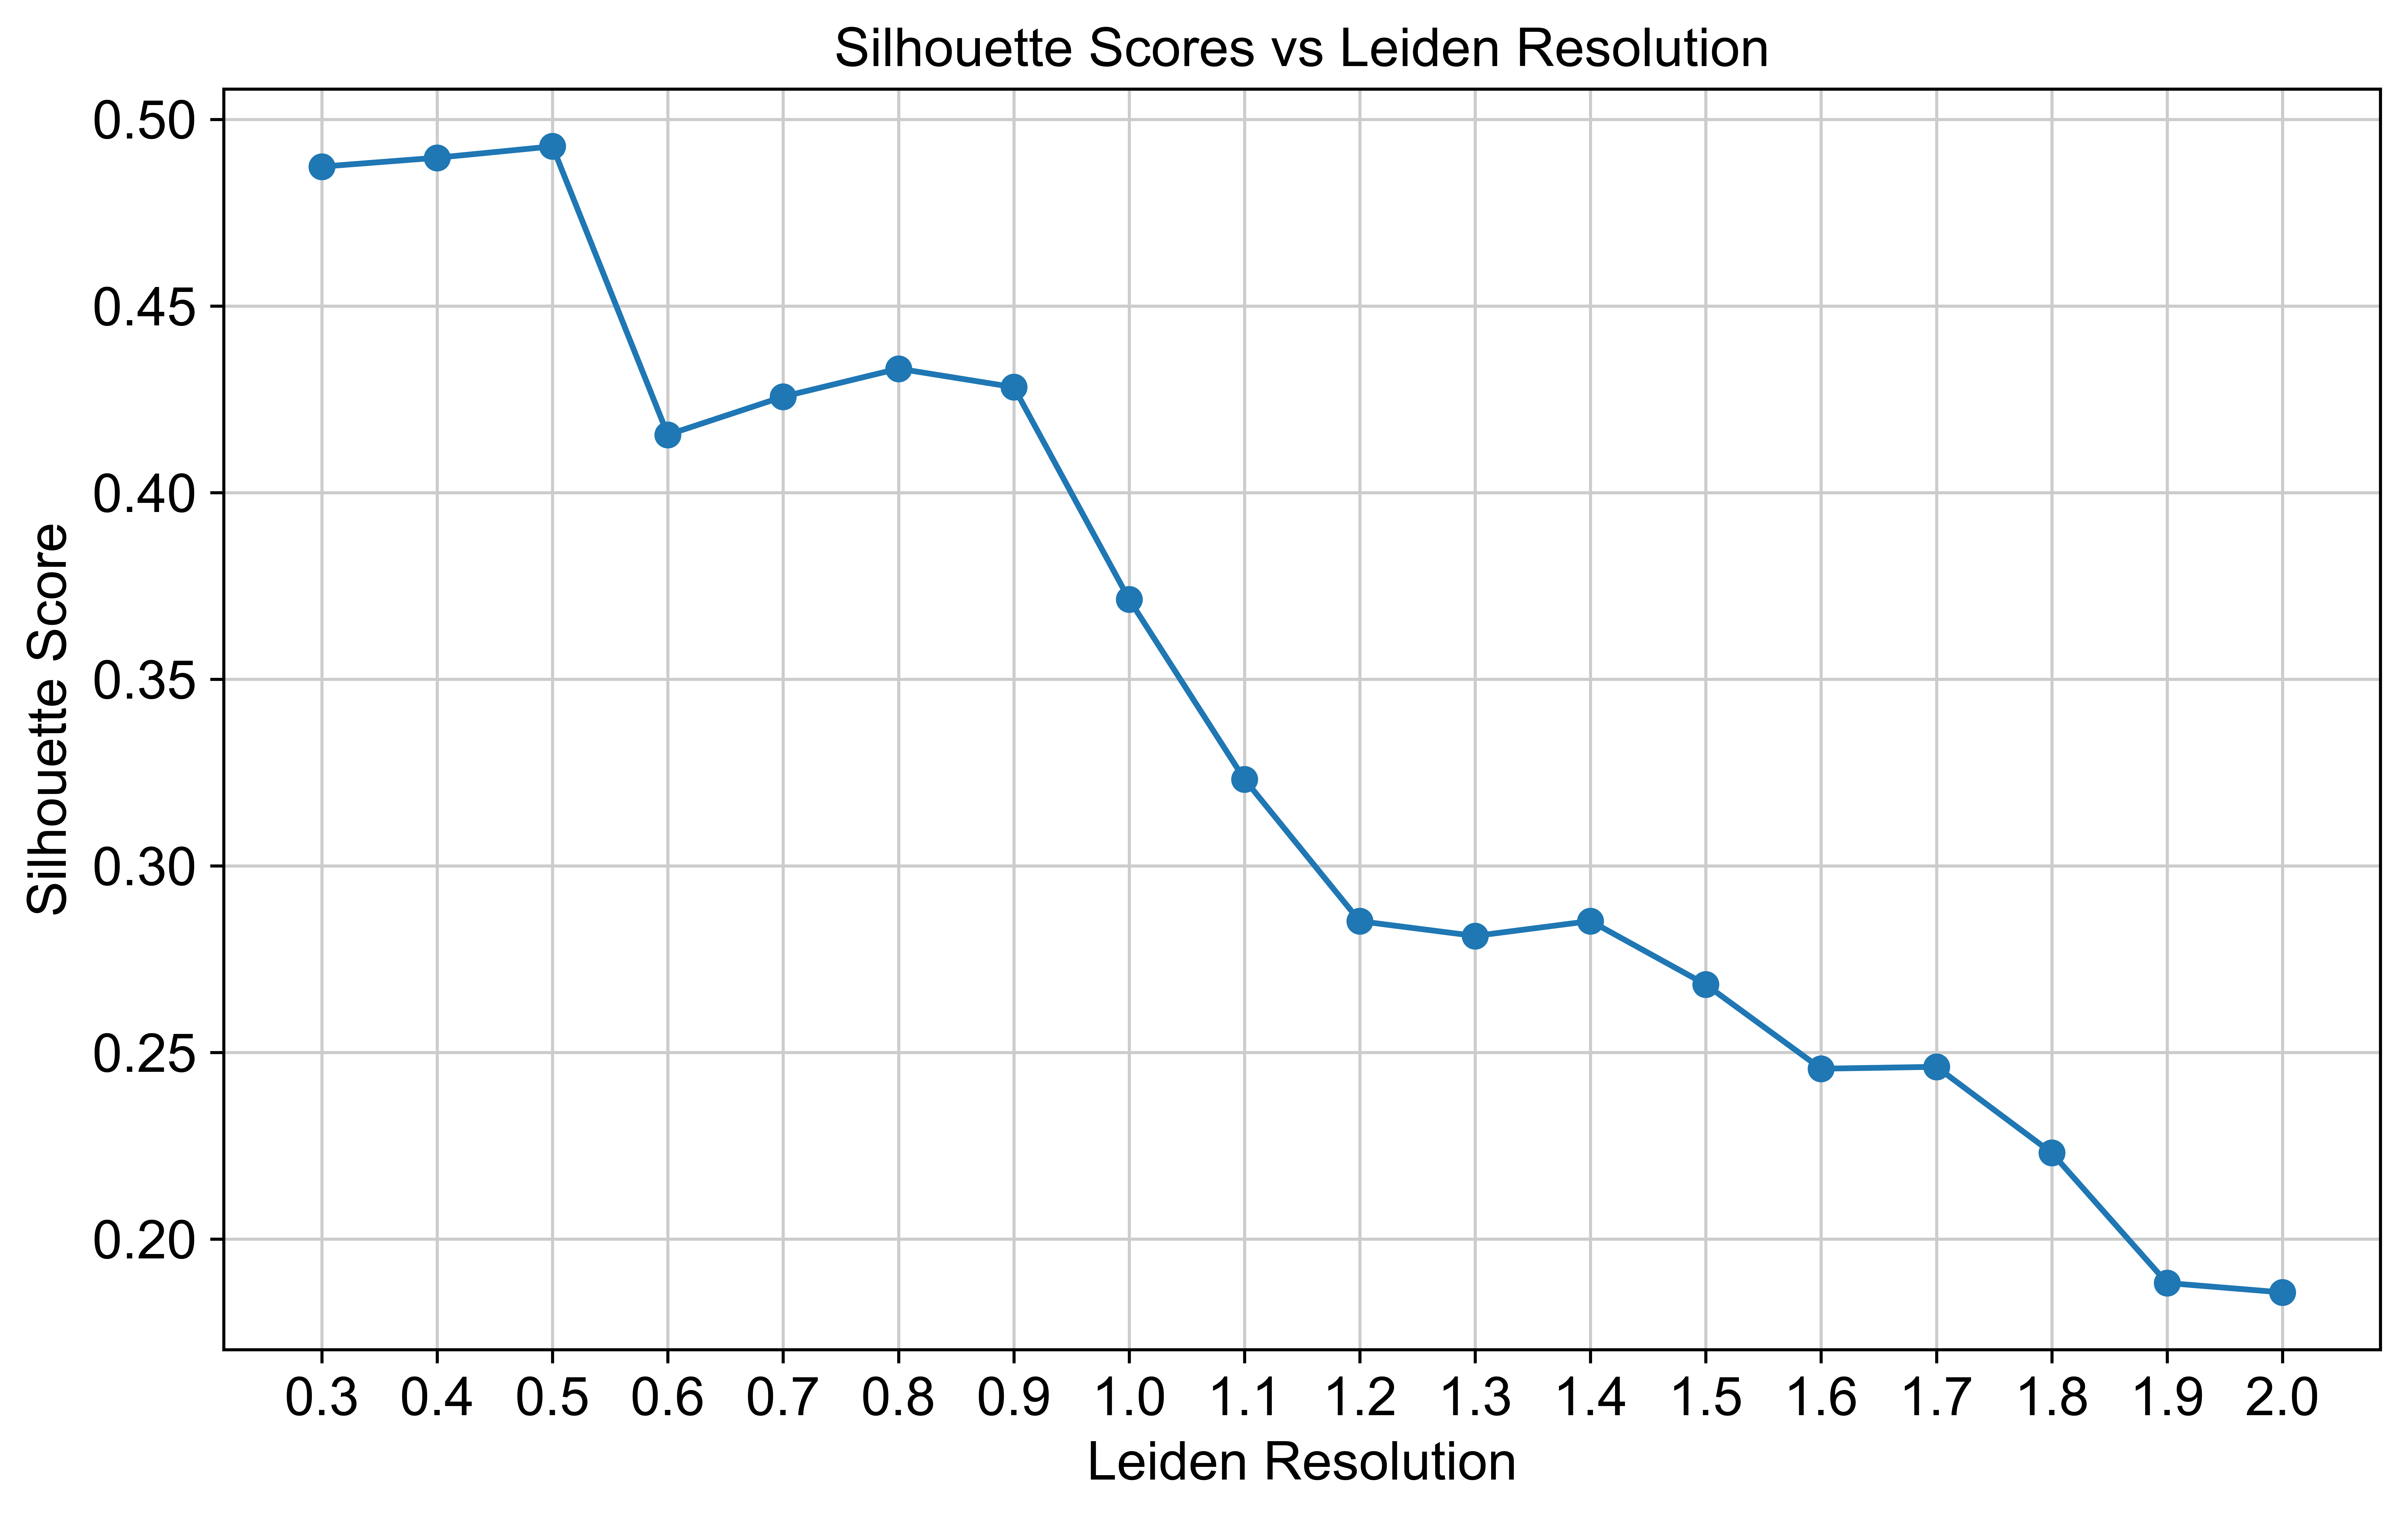

In [12]:
import sklearn
from sklearn.metrics import silhouette_score  
# define resolutions to be tested
resolutions = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

silhouette_scores = []

# calculate silhouette scores for each resolution
for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added=f"leiden_res{res}")
    
    score = sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs[f"leiden_res{res}"], metric='euclidean')
    silhouette_scores.append(score)

plt.figure(figsize=(10,6))
plt.plot(resolutions, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs Leiden Resolution')
plt.xlabel('Leiden Resolution')
plt.ylabel('Silhouette Score')
plt.xticks(resolutions)
plt.grid(True)
plt.show()


resultion 0.9 looks promising, however, we lose Tregs - thus, we are under clustered. 
Bumping up to 1.1 doesn't resolve the Treg cluster so we need to look at 1.2

In [13]:
pd.set_option('display.max_columns', None)
sc.tl.rank_genes_groups(adata, 'leiden_res1.4', method='wilcoxon')
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20))

0        1             2         3       4             5  \
0           GNLY     IL7R          GZMK     FURIN   FURIN          GZMH   
1         TYROBP     JUNB        GPR183     COTL1   IL2RA         AHNAK   
2   LOC102140945   SAMSN1           VIM      GLUL  SPOCK2          KLF3   
3           GZMH   GPR183         CXCR4   BHLHE40   CTLA4          CCL5   
4           CCL5      FOS          RGS1    NFKBIZ    RBPJ          FLNA   
5   LOC102132533    TXNIP          CD44    NFKBIA    TPI1       S100A10   
6   LOC102115168  TMEM123         ITM2C     IGF2R    TFRC        FAM65B   
7           GZMB     TCF7        FAM46C      LAG3   COTL1          ZEB2   
8          APBB2     FGL2         SMAD7    ENTPD1  ADAM19        CX3CR1   
9            TXK  ZFP36L2        PIK3R1    ADAM19    ENO1        TGFBR3   
10         KLRD1   SPOCK2          LMNA   ZC3H12A     LTB       TSC22D3   
11         OPLAH   ARID5B          FCMR      TPI1   GAPDH         ITGA4   
12       AFAP1L2    ZFP36  LOC102125623     GAPDH     LAT  LOC102128672   
13           CD7    ITGB1          ETS2      CD8B  MTHFD2          GZMB   
14        GTF3C1      CD4         RBM38      TFRC  SAMSN1          ETS2   
15         CD247   PTGER4          BTG1  SH3BGRL3    CD3D         ANXA1   
16          PRF1    RPL30  LOC102140002      LCP1    BATF       POM121C   
17          GZMA    CAMK4          CCL5      ENO1     PKM       CLEC12A   
18          LAT2     RGS1         CRTAM      CD3D  NFKBIZ          RGS9   
19         MYO1E     CD28          CST7      CD8A    ECE1         ITGB2   

               6         7             8         9       10      11       12  \
0           GZMH      CD69          CCR6      GZMK    FURIN    GZMA      FOS   
1          AHNAK   TNFAIP3         FURIN     EOMES     LAG3    GZMB     GZMK   
2         CX3CR1      IL7R          RORA     CRTAM   ENTPD1    GZMK     FOSB   
3           KLF3    NFKBIZ        MFHAS1      CCL5     CD8B   ITM2C      JUN   
4           CCL5      CD83          IL7R      FCMR    ITGA1    GZMH     RGS1   
5           FLNA      EGR1  LOC101925857    PIK3R1     JAML   COTL1  TSC22D3   
6         TGFBR3   ZC3H12A        SPOCK2    GPR183    COTL1    PRF1    TAGAP   
7          S1PR5    CSRNP1        SLAMF1     ITM2C     PRF1  ENTPD1    CXCR4   
8         SEMA3G     KLRB1          JAML      LYST    ITM2C    LAG3  GADD45B   
9        POM121C      FOSB        SAMSN1  SIGLEC14  HNRNPLL    CCL5   DNAJB1   
10        FGFBP2    NFKBIA        DUSP16     KLRG1     PTMS    CD3D    DUSP1   
11        FAM65B      RORA           CD6      CTSW     GZMB    CD8B  SERTAD1   
12          RGS9       JUN          PAG1      BEX1   ADAM19   ITGA1     KLF6   
13         KLRG1     ARL5B        S100A4     SMAD7   DENND3    CD52    ZFP36   
14       S100A10      BTG2          DPP4       TOX     GLUL    GNLY     CD69   
15        ADGRG1      CCR6           LTB    CCDC64     PERP    PAG1     ATF4   
16  LOC102128672     NR4A3      TNFRSF25     APBB2   COL5A3    CD8A    NR4A2   
17          MATK      IER2          CAPG     RBM38    IGF2R  STK17B   PMAIP1   
18      RAP1GAP2  PPP1R15A         G3BP2      CD84    ZBED2   ISG15      UBB   
19        GPR153    MFHAS1          HOPX   ARHGAP9  FAM129A   PDE4D     JUNB   

         13            14            15        16  
0      TCF7          TCF7        TYROBP     TIGIT  
1    PECAM1        PECAM1         NR4A1      BATF  
2      LEF1        RPL10A          FOSB     DUSP4  
3     ITGA6          RGS2          CD69     FOXP3  
4    GPR183         RPS14          EGR1    DUSP16  
5      FCMR          IRS2         GPR65    ARID5B  
6     S1PR1         RPL13          CD83      ICOS  
7      CCR7          RPS5          IER2     CTLA4  
8     CXCR5         GPR65          LAT2  TNFRSF18  
9    SPTBN1           CD7         ARL5B     IKZF2  
10     SELL        ZNF331          EGR2    SPOCK2  
11   SPOCK2         RPL23         RGS16      CD28  
12     PLK2         RPS19         VEGFA     ITGB1  
13     CD28          COX2     

In [14]:
pd.set_option('display.max_columns', None)
sc.tl.rank_genes_groups(adata, 'leiden_res0.9', method='wilcoxon')
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20))

0        1             2         3             4             5  \
0     GZMK     IL7R          GZMH     FURIN          GNLY         FURIN   
1   GPR183   SAMSN1         AHNAK    NFKBIA        TYROBP        SPOCK2   
2    CXCR4   ARID5B          KLF3    NFKBIZ  LOC102140945  LOC101925857   
3     RGS1   GPR183          CCL5     COTL1          GZMH          CCR6   
4     CCL5   SPOCK2          FLNA   BHLHE40          CCL5          RBPJ   
5    ITM2C    ITGB1        CX3CR1      TFRC  LOC102132533        DUSP16   
6    SMAD7     CD28       S100A10   ZC3H12A  LOC102115168        SLAMF1   
7   PIK3R1      CD4        FAM65B      TPI1          GZMB         COTL1   
8     FCMR     JUNB        TGFBR3    ADAM19         APBB2          RORA   
9    EOMES     FGL2          ZEB2     GAPDH           TXK           CD6   
10   CRTAM     ICOS       POM121C     IL2RA         KLRD1           LTB   
11    ETS2  TMEM123  LOC102128672      ENO1         OPLAH        S100A4   
12    CTSW     RGS1        SEMA3G       LTB       AFAP1L2           LAT   
13  FAM46C     TCF7          RGS9    ENTPD1           CD7      SH3BGRL3   
14   RBM38  ZFP36L2          GZMB      CD3D        GTF3C1          DPP4   
15    LYST    TXNIP       CLEC12A      GLUL         CD247        SAMSN1   
16    LMNA    RPL30          MATK       LAT          PRF1        ADAM19   
17    CST7   PTGER4         CLIC5     IGF2R          GZMA        MFHAS1   
18  HIVEP2    SYNE2         ITGA4      BATF          LAT2      TNFRSF25   
19  CCDC64      FOS         S1PR5  SH3BGRL3         MYO1E           CD2   

           6         7             8             9  
0       GZMA      CD69          TCF7        TYROBP  
1       GZMB   TNFAIP3        PECAM1         NR4A1  
2      ITM2C      IL7R          IRS2          CD69  
3      COTL1      CD83          LEF1          FOSB  
4       GZMK    NFKBIZ        SPTBN1          EGR1  
5       LAG3      EGR1          SELL         GPR65  
6       PRF1   ZC3H12A        ZBTB10          CD83  
7     ENTPD1    CSRNP1           CD7          IER2  
8       CD8B      RORA          PLK2         ARL5B  
9      ITGA1     KLRB1  LOC102132295          LAT2  
10     FURIN    NFKBIA        ZNF331          EGR2  
11      CD52      FOSB           ND2         RGS16  
12      GZMH     ARL5B          AKT3         VEGFA  
13      CD3D       JUN       TMEM213  LOC102115805  
14      CD8A      BTG2         CXCR5         NR4A2  
15    ADAM19      CCR6         ITGA6          TCF7  
16      PAG1     NR4A3          BEX1      HSP90AB1  
17      HOPX    MFHAS1          FCMR           CD7  
18  SH3BGRL3      IER2        GAPDHS  LOC102116023  
19      CCR2  PPP1R15A          DGKA        NFKBIZ

In [15]:
# leideon 0.9 underclustered (no Treg cluster was present). Other clusters split and were not meaningful with 1.4 so lets collapse some
treg_cluster_label_1_4 = '16'  
treg_cells = adata.obs['leiden_res1.4'] == treg_cluster_label_1_4
adata.obs['mixed_res_cluster'] = adata.obs['leiden_res0.9']
current_categories = adata.obs['mixed_res_cluster'].cat.categories.tolist()
unique_labels_0_9 = set(adata.obs['leiden_res0.9'])
max_label_0_9 = max([int(label) for label in unique_labels_0_9])
new_treg_label = str(max_label_0_9 + 1) 
new_categories = current_categories + [new_treg_label]
adata.obs['mixed_res_cluster'] = pd.Categorical(adata.obs['mixed_res_cluster'], categories=new_categories)
adata.obs.loc[treg_cells, 'mixed_res_cluster'] = new_treg_label

In [108]:
pd.set_option('display.max_columns', None)
#sc.tl.rank_genes_groups(adata, 'mixed_res_cluster', method='wilcoxon')
display(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(50))


0         1             2             3             4  \
0           GZMK      IL7R          GZMH         FURIN          GNLY   
1         GPR183    SAMSN1         AHNAK        NFKBIA        TYROBP   
2          CXCR4    GPR183          KLF3        NFKBIZ  LOC102140945   
3           RGS1    ARID5B          CCL5         COTL1          GZMH   
4           CCL5    SPOCK2          FLNA       BHLHE40          CCL5   
5          ITM2C     ITGB1        CX3CR1          TFRC  LOC102132533   
6          SMAD7      FGL2       S100A10       ZC3H12A  LOC102115168   
7         PIK3R1      TCF7        FAM65B          TPI1          GZMB   
8           FCMR      JUNB        TGFBR3        ADAM19         APBB2   
9          EOMES       CD4          ZEB2         GAPDH           TXK   
10         CRTAM   TMEM123       POM121C         IL2RA         KLRD1   
11          ETS2     TXNIP  LOC102128672          ENO1         OPLAH   
12          CTSW      CD28        SEMA3G           LTB       AFAP1L2   
13        FAM46C    PTGER4          RGS9        ENTPD1           CD7   
14         RBM38       FOS          GZMB          CD3D        GTF3C1   
15          LYST     CAMK4       CLEC12A          GLUL         CD247   
16          LMNA   ZFP36L2          MATK           LAT          PRF1   
17          CST7     RPL30         CLIC5         IGF2R          GZMA   
18        HIVEP2      ICOS         ITGA4          BATF          LAT2   
19        CCDC64      CAPG         S1PR5      SH3BGRL3         MYO1E   
20        PMAIP1     ITGA6        ADGRG1           TNF         CCND2   
21          CD84      DGKA         KLRG1           PKM          RGS9   
22          KLF6      RGS1        FGFBP2        SPOCK2         S1PR5   
23          CD44     ZFP36         PTPN4          LCP1        CX3CR1   
24       TSC22D3     SYNE2          ETS2          GALM          CST7   
25          CD74   ANKRD12         SYNE1          ECE1        PDGFRB   
26          CCR5    IFITM1        GPR153           CD2          RHOC   
27        IPCEF1       MAF          CST7          RBPJ          THY1   
28        SLAMF6     RPS14      RAP1GAP2         ACTG1          MATK   
29          WNK1       CD5          CD84         YWHAQ          VAV3   
30           VIM     DPEP2       RASGRP2         CTLA4         PDE4D   
31         CLIC5     RPL13         SSBP4          CD69          HOPX   
32       ARHGAP9      RPS5  LOC102122037        MTHFD2       PITPNC1   
33        CDC14A    GIMAP7         PRR5L      TNFRSF25       UBASH3B   
34         ATXN7     BIRC3         ITGB2          LAG3       COL11A1   
35         ATHL1  TNFRSF25          NKG7          JUNB         KLRF1   
36          PAG1     S1PR1        GTF3C1          IDH2          NKG7   
37         BCAT1    RPL10A         CD226           ADA         NUCB2   
38          BEX1     ITM2A         ANXA1       TNFAIP3        ADGRG1   
39  LOC102136468    SLC2A3         RASA3      PPP1R15A          TESC   
40           TOX      TPT1         PCDH1         PDGFA           SYK   
41          BTG1      LEF1       SPATA13          RAC2         PTPN4   
42  LOC102140002    DUSP16         TMEM2       FAM129A        GPR153   
43           FOS     RPLP0         ISCA1  LOC102138723          CLNK   
44      SIGLEC14     RPS19         STK38         HSPA8        PRSS57   
45  LOC102133757    ABLIM1      SERPINA1         STX11        FGFBP2   
46         MYADM    MFHAS1         KLRD1      HSP90AB1         RUNX3   
47         TAGAP    GNB2L1       TSC22D3           FYN          JAK1   
48          ERN1     RPL11        VANGL1       HNRNPAB  LOC102115251   
49          ATF4      RPS3         PDZD4  LOC101925857         KLRB1   

               5             6         7             8             9        10  
0          FURIN          GZMA      CD69          TCF7        TYROBP     TIGIT  
1         SPOCK2          GZMB   TNFAIP3        PECAM1         NR4A1      BATF  
2   LOC101925857         ITM2C      IL7R          IRS2          CD69     DUSP4  
3           CCR6  

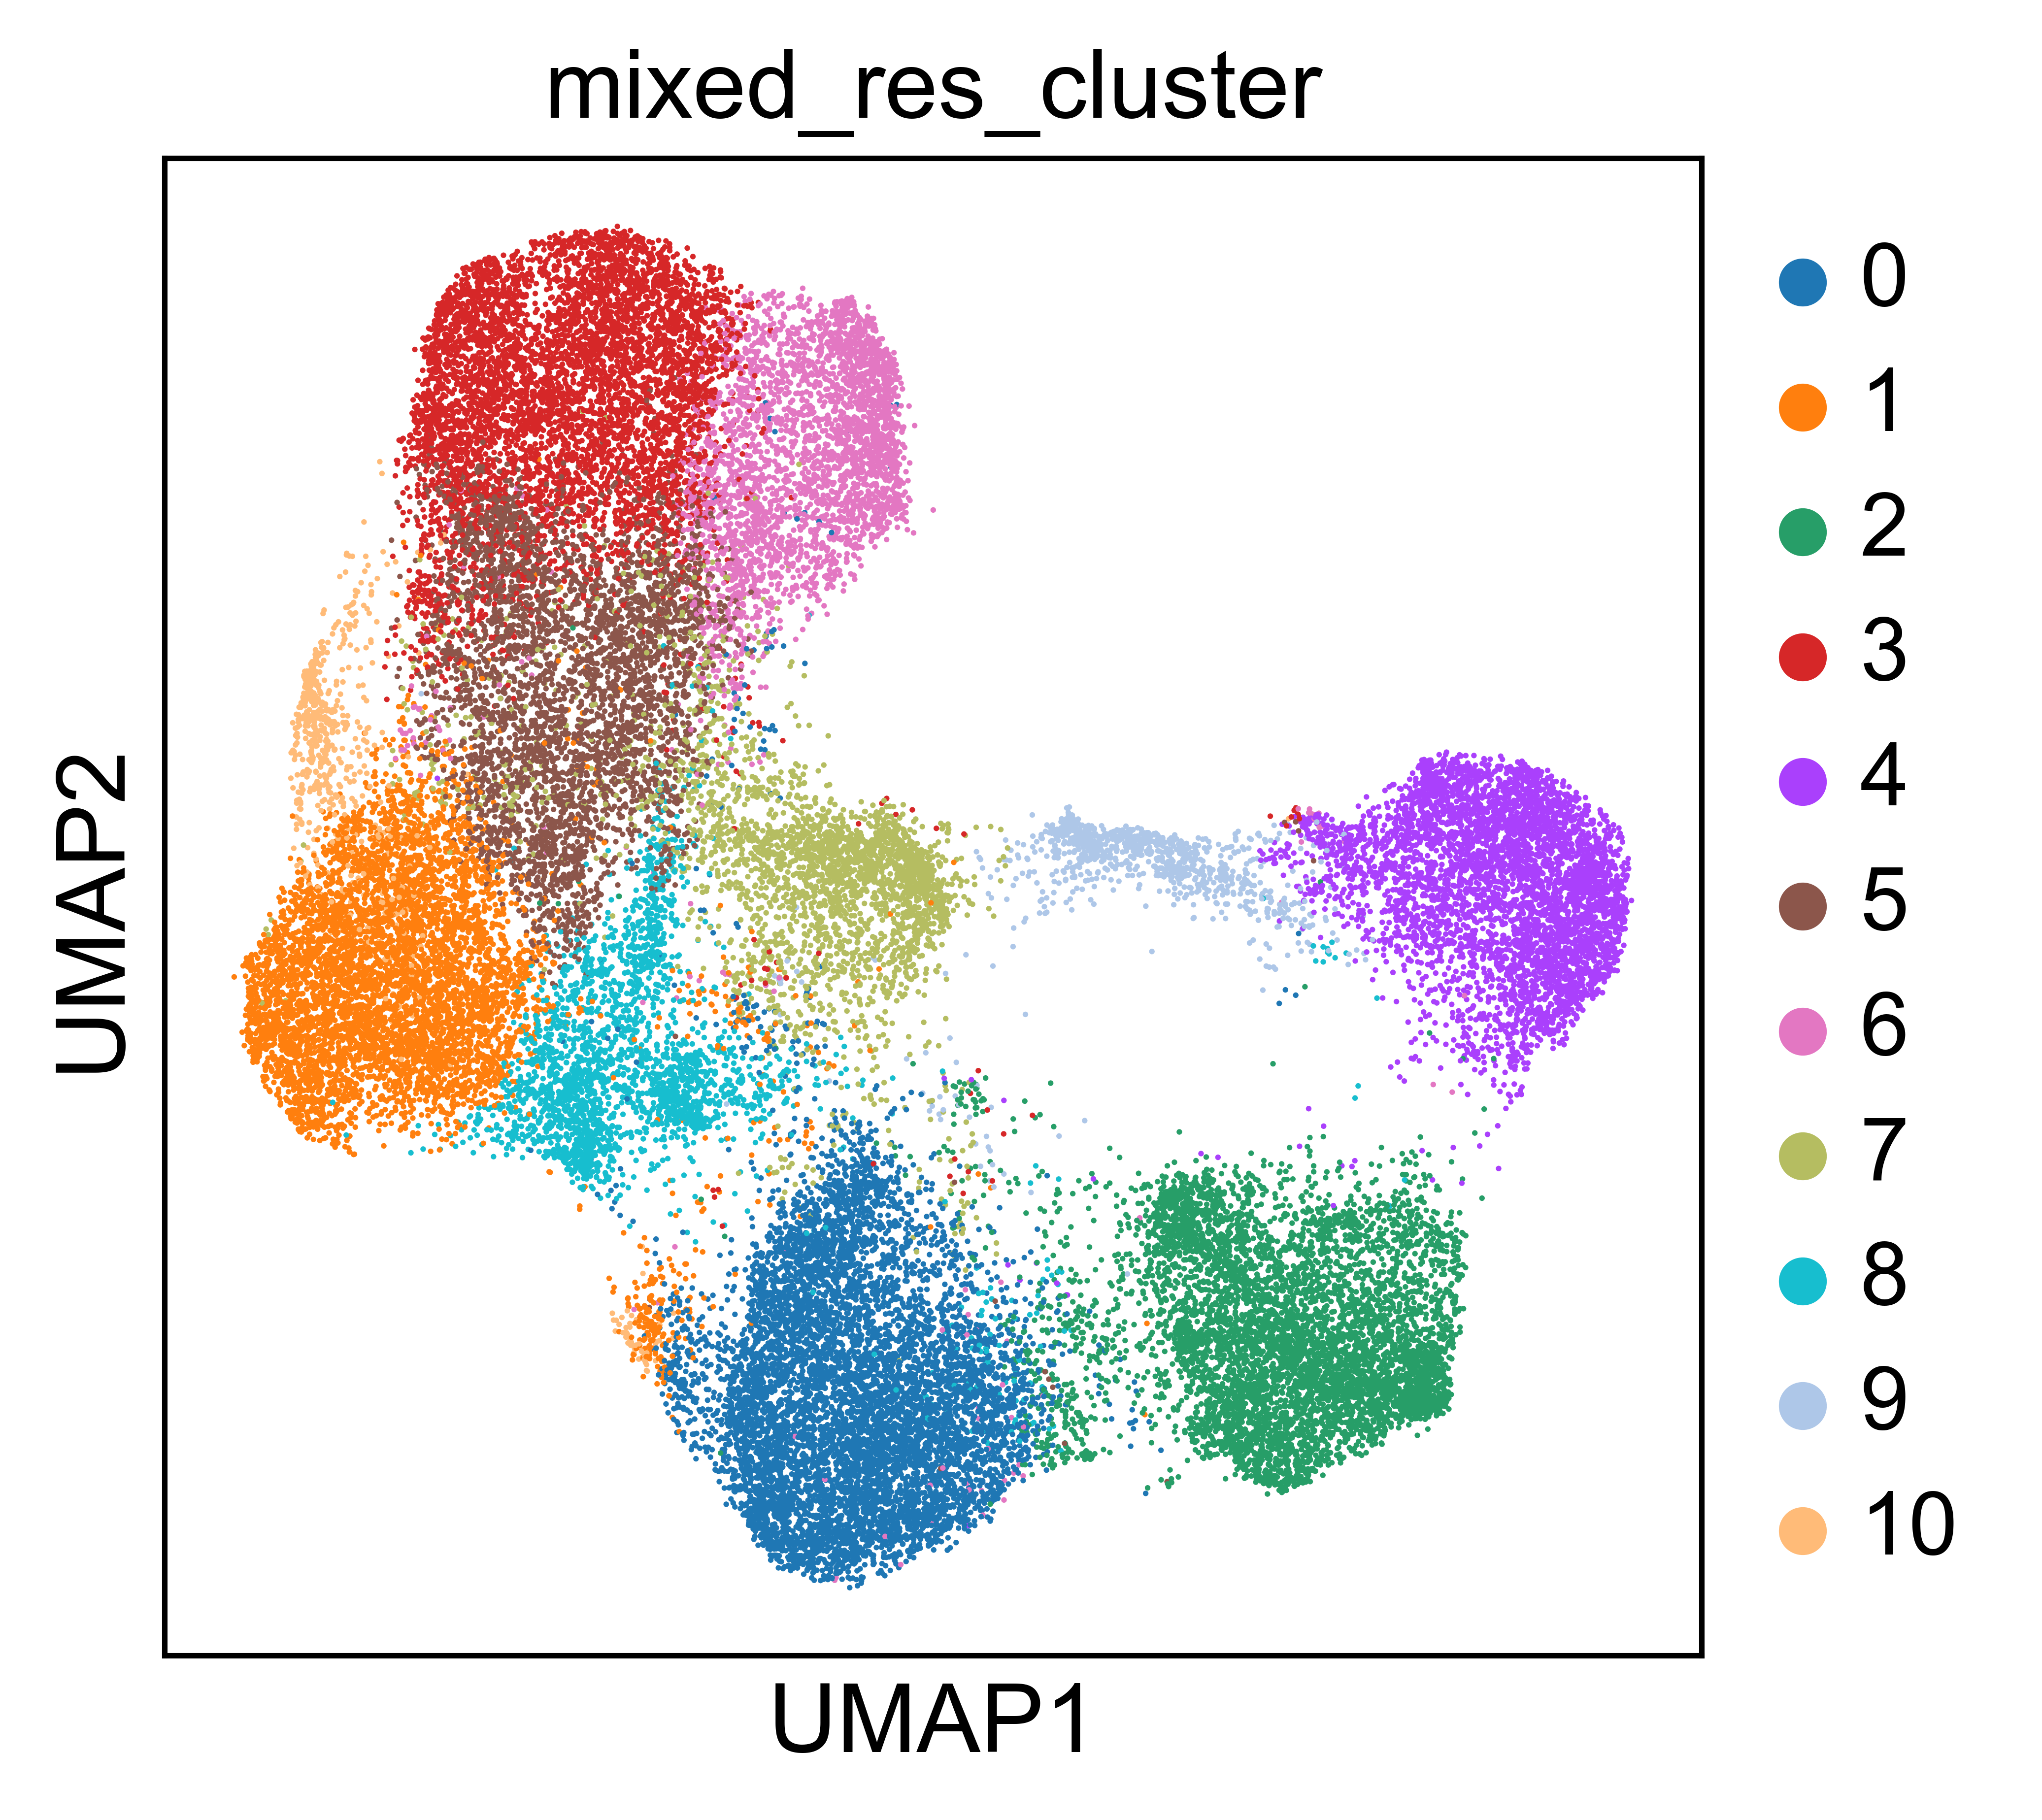

In [16]:
sc.pl.umap(adata, color = ["mixed_res_cluster"])

# 3. Annotate Leiden-based Clusters

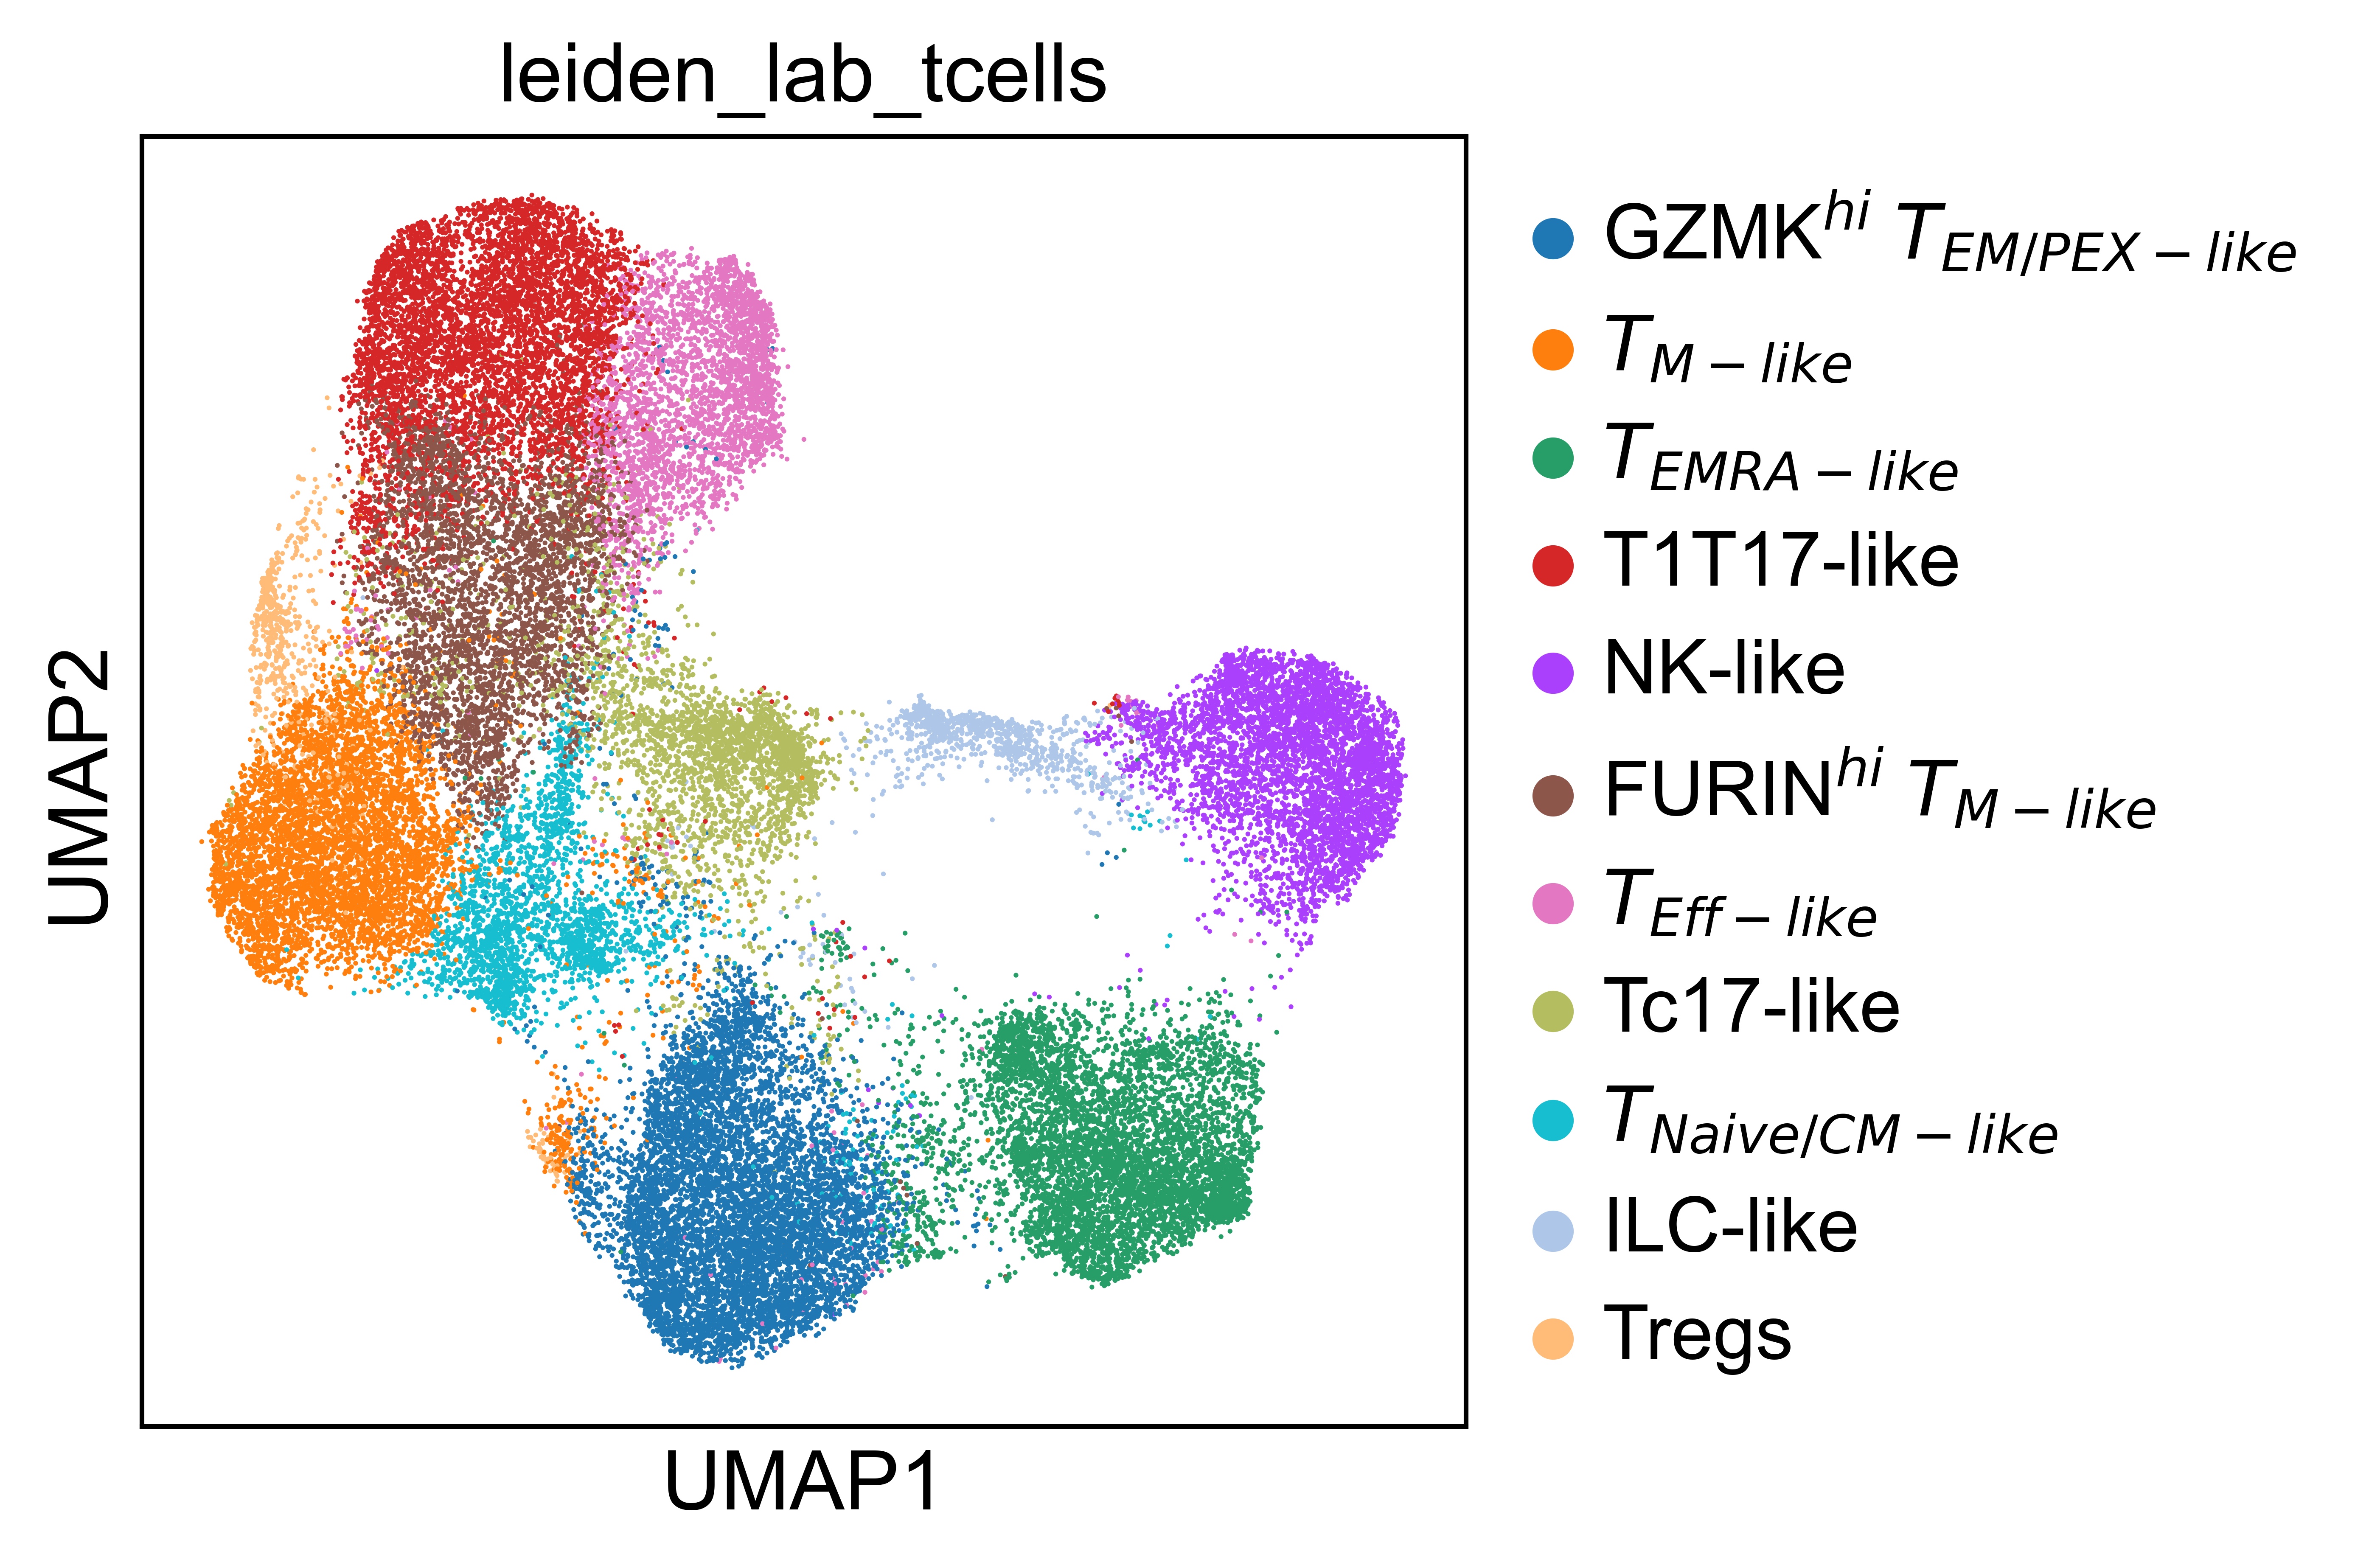

In [18]:
labmap2 = {'0':'GZMK$^{hi}$ $T_{EM/PEX-like}$',
          '1':'$T_{M-like}$',
          '2':'$T_{EMRA-like}$',
          '3':'T1T17-like',
          '4':'NK-like',
          '5':'FURIN$^{hi}$ $T_{M-like}$',
          '6':'$T_{Eff-like}$',
          '7':'Tc17-like',
          '8':'$T_{Naive/CM-like}$',
          '9':'ILC-like',
          '10':'Tregs'}
adata.obs['leiden_lab_tcells'] = adata.obs['mixed_res_cluster'].replace(labmap2)
sc.pl.umap(adata, color=['leiden_lab_tcells'])

In [19]:
adata_allcells.obs['Subclustering'] = adata_allcells.obs['Subclustering'].astype(str)
adata_allcells.obs.loc[adata.obs.index, 'Subclustering'] = adata.obs['leiden_lab_tcells']
#Save adata_allcells h5ad file w/subclustering idents
adata_allcells.write_h5ad("./Scanpy_H5AD/adata_Final_for_Reinfection_publication.h5ad")
